<a href="https://colab.research.google.com/github/MahnoorShahbaz/Credit-Card-Fraud-Detection/blob/main/notebooks/ML_Project_XG_Boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Using XG Boost
#Importing library

!pip install imbalanced-learn xgboost --quiet

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)



In [2]:
#Loading dataset
from zipfile import ZipFile

with ZipFile("/content/archive (2).zip", "r") as z:
    z.extractall("/content/archive_extracted")

Number of each class:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage of each class(%):
Class
0    99.8273
1     0.1727
Name: proportion, dtype: float64


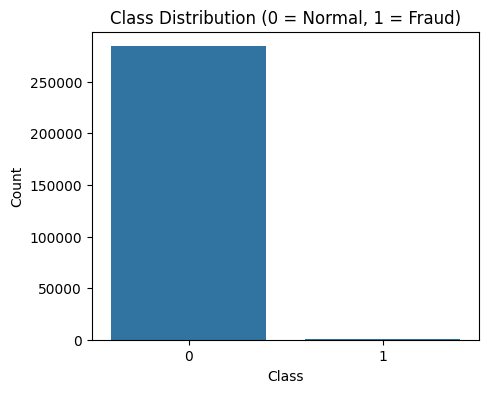

In [3]:
import pandas as pd
df = pd.read_csv('/content/archive_extracted/creditcard.csv')

#Check imbalance of data
#Very important step
class_counts = df['Class'].value_counts()
class_ratio = df['Class'].value_counts(normalize=True) * 100

print("Number of each class:")
print(class_counts)
print("\nPercentage of each class(%):")
print(class_ratio.round(4))

plt.figure(figsize=(5,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [4]:
#Train-Test Split
RANDOM_STATE = 42 # Define RANDOM_STATE for reproducibility
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
    #random state ensures states are reproducible
)

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)

print("\nClass Distribution of Training Set:")
print(y_train.value_counts())

print("\nClass Distribution of Testing Set:")
print(y_test.value_counts())

Shape X_train: (227845, 30)
Shape X_test : (56962, 30)

Class Distribution of Training Set:
Class
0    227451
1       394
Name: count, dtype: int64

Class Distribution of Testing Set:
Class
0    56864
1       98
Name: count, dtype: int64


In [5]:
from imblearn.over_sampling import SMOTE

smote_demo = SMOTE(random_state=RANDOM_STATE)
X_res_demo, y_res_demo = smote_demo.fit_resample(X_train, y_train)

print("Before SMOTE (train):")
print(y_train.value_counts())

print("\nAfter SMOTE (train, demo):")
print(y_res_demo.value_counts())

Before SMOTE (train):
Class
0    227451
1       394
Name: count, dtype: int64

After SMOTE (train, demo):
Class
0    227451
1    227451
Name: count, dtype: int64


In [6]:
param_bounds = {
    'n_estimators':      (100, 500),   # integer
    'max_depth':         (3, 10),      # integer
    'learning_rate':     (0.01, 0.3),  # float
    'subsample':         (0.6, 1.0),   # float
    'colsample_bytree':  (0.6, 1.0),   # float
    'min_child_weight':  (1, 10),      # integer
    'gamma':             (0.0, 5.0),   # float
    'reg_lambda':        (0.0, 10.0)   # float
}

param_names = list(param_bounds.keys())

def decode_position_to_params(position):
    """
   Mapping a continuous position vector to XGBoost hyperparameters.
    """
    params = {}
    for i, name in enumerate(param_names):
        low, high = param_bounds[name]
        val = float(position[i])

        val = max(min(val, high), low)

        if name in ['n_estimators', 'max_depth', 'min_child_weight']:
            params[name] = int(round(val))
        else:
            params[name] = float(val)
    return params

# Check the decoding example
test_pos = np.array([param_bounds[name][0] for name in param_names])
print("Decoding Example:", decode_position_to_params(test_pos))

Decoding Example: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'gamma': 0.0, 'reg_lambda': 0.0}


In [7]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def objective_xgb(params):
    """
   params: dict XGBoost hyperparameters
    return: mean ROC-AUC (higher is better)
    """
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',    # biasanya paling cepat di CPU
        n_jobs=-1,
        random_state=RANDOM_STATE,
        **params
    )

    pipeline = ImbPipeline(steps=[
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', model)
    ])
    scores = cross_val_score(
        pipeline,
        X_train, y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    return scores.mean()


test_params = decode_position_to_params(test_pos)
print("ROC-AUC (CV) example:", objective_xgb(test_params))

ROC-AUC (CV) example: 0.9778241165187279


In [8]:
def boa_optimize(
    objective_func,
    n_butterflies=10,
    n_iterations=10,
    p=0.8,         # probability global search
    a=0.1,         # power exponent for fragrance
    c=0.01,        # sensory modality
    random_state=RANDOM_STATE
):
    """
    Simple implementation of the Butterfly Optimization Algorithm (BOA)
    for a MAXIMIZATION problem (here: ROC-AUC).

    Parameters
    ----------
    objective_func : function
        A function that accepts a dictionary of hyperparameters and returns a score (higher is better).
    n_butterflies : int
        Population size.
    n_iterations : int
        Number of BOA iterations.
    p : float
        Probability of global search.
    a, c : float
        Fragrance parameters in BOA.
    random_state : int
        Seed for the random number generator.

    Returns
    -------
    best_params : dict
        The best XGBoost hyperparameters found.
    best_score : float
        The best cross-validation ROC-AUC score.
    history : list
        Record of the best_score for each iteration.
    """
    rng = np.random.RandomState(random_state)
    dim = len(param_names)
    lb = np.array([param_bounds[name][0] for name in param_names])
    ub = np.array([param_bounds[name][1] for name in param_names])

    # Initialize population (initial butterfly positions)
    population = lb + (ub - lb) * rng.rand(n_butterflies, dim)

    # Initial evaluation
    scores = []
    for pos in population:
        params = decode_position_to_params(pos)
        score = objective_func(params)
        scores.append(score)
    scores = np.array(scores)

    best_idx = np.argmax(scores)
    best_pos = population[best_idx].copy()
    best_score = scores[best_idx]

    history = [best_score]
    print("BOA Initialization:")
    print(f"  Initial Best ROC-AUC: {best_score:.5f}")
    print(f"  Initial Best Params: {decode_position_to_params(best_pos)}\n")

    # BOA Iterations
    for t in range(n_iterations):
        for i in range(n_butterflies):
            current_pos = population[i].copy()
            current_score = scores[i]

            # Calculate fragrance (based on score)
            # score >= 0, so it is safe to exponentiate
            fragrance = c * (current_score ** a)

            # Global or local search
            if rng.rand() < p:
                # GLOBAL SEARCH
                # Movement toward the global best solution (best_pos)
                r = rng.rand()
                new_pos = current_pos + (r ** 2) * (best_pos - current_pos) * fragrance
            else:
                # LOCAL SEARCH
                # Random movement relative to two other butterflies (j and k)
                jk = rng.choice(n_butterflies, 2, replace=False)
                j, k = jk[0], jk[1]
                r = rng.rand()
                new_pos = current_pos + (r ** 2) * (population[j] - population[k]) * fragrance

            # Boundary check (Clamping the position within the defined hyperparameter bounds)
            new_pos = np.clip(new_pos, lb, ub)

            # Evaluate new solution
            new_params = decode_position_to_params(new_pos)
            new_score = objective_func(new_params)

            # If better, update the individual butterfly
            if new_score > current_score:
                population[i] = new_pos
                scores[i] = new_score
                current_score = new_score

            # Update global best
            if new_score > best_score:
                best_score = new_score
                best_pos = new_pos.copy()

        history.append(best_score)
        print(f"Iteration {t+1}/{n_iterations} - Best ROC-AUC: {best_score:.5f}")

    best_params = decode_position_to_params(best_pos)
    return best_params, best_score, history

In [9]:
best_params, best_score, history = boa_optimize(
    objective_func=objective_xgb,
    n_butterflies=20,
    n_iterations=20,
    p=0.8,
    a=0.1,
    c=0.01,
    random_state=RANDOM_STATE
)

print("\nFinal BOA Result")
print("Best ROC-AUC (CV) :", best_score)
print("Best Hyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

BOA Initialization:
  Initial Best ROC-AUC: 0.98294
  Initial Best Params: {'n_estimators': 423, 'max_depth': 9, 'learning_rate': 0.10222100774184051, 'subsample': 0.6440207698110707, 'colsample_bytree': 0.6911740650167767, 'min_child_weight': 5, 'gamma': 4.090073829612465, 'reg_lambda': 8.607305832563434}

Iteration 1/20 - Best ROC-AUC: 0.98433
Iteration 2/20 - Best ROC-AUC: 0.98433
Iteration 3/20 - Best ROC-AUC: 0.98433
Iteration 4/20 - Best ROC-AUC: 0.98466
Iteration 5/20 - Best ROC-AUC: 0.98466
Iteration 6/20 - Best ROC-AUC: 0.98466
Iteration 7/20 - Best ROC-AUC: 0.98466
Iteration 8/20 - Best ROC-AUC: 0.98466
Iteration 9/20 - Best ROC-AUC: 0.98466
Iteration 10/20 - Best ROC-AUC: 0.98466
Iteration 11/20 - Best ROC-AUC: 0.98466
Iteration 12/20 - Best ROC-AUC: 0.98466
Iteration 13/20 - Best ROC-AUC: 0.98466
Iteration 14/20 - Best ROC-AUC: 0.98466
Iteration 15/20 - Best ROC-AUC: 0.98466
Iteration 16/20 - Best ROC-AUC: 0.98466
Iteration 17/20 - Best ROC-AUC: 0.98466
Iteration 18/20 - Be

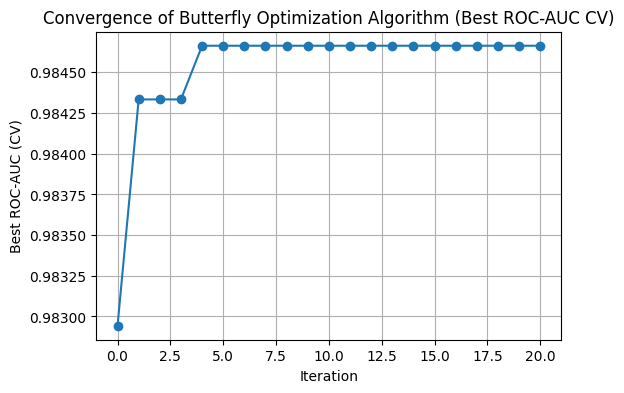

In [10]:
plt.figure(figsize=(6,4))
plt.plot(history, marker="o")
plt.title("Convergence of Butterfly Optimization Algorithm (Best ROC-AUC CV)")
plt.xlabel("Iteration")
plt.ylabel("Best ROC-AUC (CV)")
plt.grid(True)
plt.show()

In [11]:
final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    **best_params
)

final_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', final_model)
])

print("Training the final pipeline with the best hyperparameters...")
final_pipeline.fit(X_train, y_train)


y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]
print("Training Complete.")

Training the final pipeline with the best hyperparameters...
Training Complete.


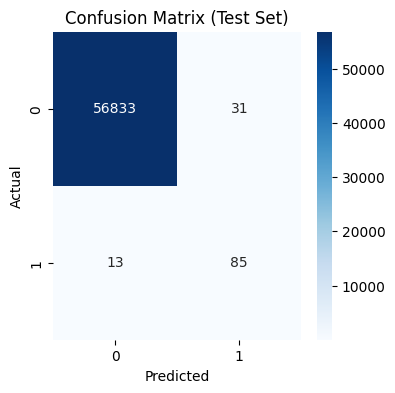


Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9998    0.9995    0.9996     56864
           1     0.7328    0.8673    0.7944        98

    accuracy                         0.9992     56962
   macro avg     0.8663    0.9334    0.8970     56962
weighted avg     0.9993    0.9992    0.9993     56962

ROC-AUC (Test) : 0.980840
PR-AUC  (Test) : 0.875691


In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=4))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC (Test) : {roc_auc:.6f}")

# Precision-Recall & PR-AUC
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC  (Test) : {pr_auc:.6f}")

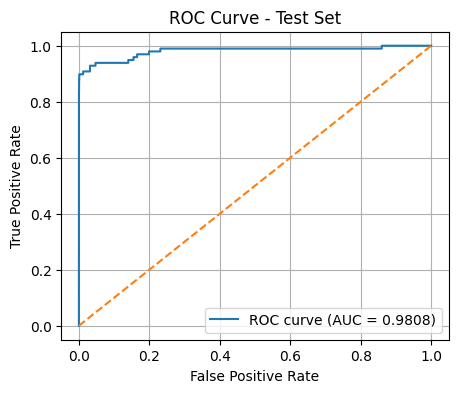

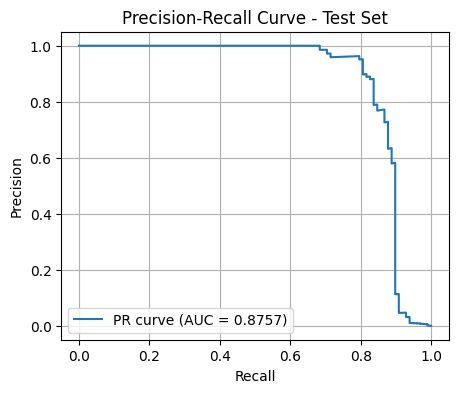

In [14]:
# ============================================================
# 13. PLOT ROC CURVE & PRECISION-RECALL CURVE
# ============================================================

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(5,4))
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test Set")
plt.legend()
plt.grid(True)
plt.show()

Best Threshold (based on F1-score on the test set): 0.970
F1-score at that Threshold       : 0.866667

Classification Report with the Best Threshold:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9512    0.7959    0.8667        98

    accuracy                         0.9996     56962
   macro avg     0.9754    0.8979    0.9332     56962
weighted avg     0.9996    0.9996    0.9996     56962



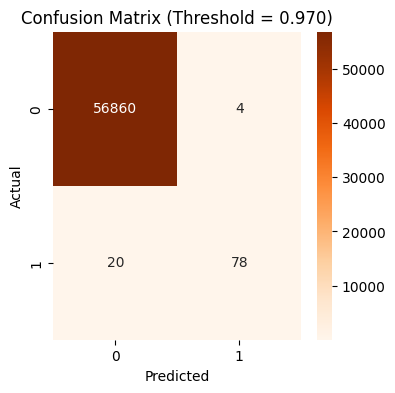

In [15]:
from sklearn.metrics import f1_score

best_f1 = 0
best_thr = 0.5

for thr in np.linspace(0.01, 0.99, 99):
    y_pred_thr = (y_proba >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print(f"Best Threshold (based on F1-score on the test set): {best_thr:.3f}")
print(f"F1-score at that Threshold       : {best_f1:.6f}")

y_pred_best = (y_proba >= best_thr).astype(int)
print("\nClassification Report with the Best Threshold:")
print(classification_report(y_test, y_pred_best, digits=4))

cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4,4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Oranges")
plt.title(f"Confusion Matrix (Threshold = {best_thr:.3f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
from sklearn.pipeline import Pipeline as SkPipeline

baseline1_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

baseline1_pipeline = SkPipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', baseline1_model)
])

print("Training Baseline 1 (XGB default, without SMOTE, without BOA)...")
baseline1_pipeline.fit(X_train, y_train)

y_pred_b1 = baseline1_pipeline.predict(X_test)
y_proba_b1 = baseline1_pipeline.predict_proba(X_test)[:, 1]
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

print("\n=== BASELINE 1 - Evaluation Results (without SMOTE, without BOA) ===")
print(classification_report(y_test, y_pred_b1, digits=4))

roc_auc_b1 = roc_auc_score(y_test, y_proba_b1)
precision_b1, recall_b1, _ = precision_recall_curve(y_test, y_proba_b1)
pr_auc_b1 = auc(recall_b1, precision_b1)

print(f"ROC-AUC : {roc_auc_b1:.6f}")
print(f"PR-AUC  : {pr_auc_b1:.6f}")

Training Baseline 1 (XGB default, without SMOTE, without BOA)...

=== BASELINE 1 - Evaluation Results (without SMOTE, without BOA) ===
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56864
           1     0.8667    0.7959    0.8298        98

    accuracy                         0.9994     56962
   macro avg     0.9332    0.8979    0.9148     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC-AUC : 0.938952
PR-AUC  : 0.797284


In [17]:
baseline2_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

baseline2_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', baseline2_model)
])

print("Training Baseline 2 (XGB default + SMOTE, without BOA)...")
baseline2_pipeline.fit(X_train, y_train)

y_pred_b2 = baseline2_pipeline.predict(X_test)
y_proba_b2 = baseline2_pipeline.predict_proba(X_test)[:, 1]

print("\n=== BASELINE 2 - Evaluation Results (XGB + SMOTE, without BOA) ===")
print(classification_report(y_test, y_pred_b2, digits=4))
roc_auc_b2 = roc_auc_score(y_test, y_proba_b2)
precision_b2, recall_b2, _ = precision_recall_curve(y_test, y_proba_b2)
pr_auc_b2 = auc(recall_b2, precision_b2)

print(f"ROC-AUC : {roc_auc_b2:.6f}")
print(f"PR-AUC  : {pr_auc_b2:.6f}")

Training Baseline 2 (XGB default + SMOTE, without BOA)...

=== BASELINE 2 - Evaluation Results (XGB + SMOTE, without BOA) ===
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56864
           1     0.7281    0.8469    0.7830        98

    accuracy                         0.9992     56962
   macro avg     0.8639    0.9232    0.8913     56962
weighted avg     0.9993    0.9992    0.9992     56962

ROC-AUC : 0.979983
PR-AUC  : 0.868143


In [18]:
from sklearn.metrics import f1_score


report_b1 = classification_report(y_test, y_pred_b1, output_dict=True)
report_b2 = classification_report(y_test, y_pred_b2, output_dict=True)
report_boa = classification_report(y_test, y_pred,  output_dict=True)

summary = pd.DataFrame([
    {
        "Model": "Baseline 1 (XGB default, n  SMOTE)",
        "Recall_fraud":  report_b1["1"]["recall"],
        "Precision_fraud": report_b1["1"]["precision"],
        "F1_fraud": report_b1["1"]["f1-score"],
        "ROC_AUC": roc_auc_b1,
        "PR_AUC": pr_auc_b1
    },
    {
        "Model": "Baseline 2 (XGB + SMOTE, no BOA)",
        "Recall_fraud":  report_b2["1"]["recall"],
        "Precision_fraud": report_b2["1"]["precision"],
        "F1_fraud": report_b2["1"]["f1-score"],
         "ROC_AUC": roc_auc_b2,
        "PR_AUC": pr_auc_b2
    },
    {
        "Model": "Proposed (XGB + SMOTE + BOA)",
        "Recall_fraud":  report_boa["1"]["recall"],
        "Precision_fraud": report_boa["1"]["precision"],
        "F1_fraud": report_boa["1"]["f1-score"],
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc
    }
])

pd.set_option("display.float_format", lambda x: f"{x:0.4f}")
display(summary)

,Model,Recall_fraud,Precision_fraud,F1_fraud,ROC_AUC,PR_AUC
0,"Baseline 1 (XGB default, n SMOTE)",0.7959,0.8667,0.8298,0.9390,0.7973
1,"Baseline 2 (XGB + SMOTE, no BOA)",0.8469,0.7281,0.7830,0.9800,0.8681
2,Proposed (XGB + SMOTE + BOA),0.8673,0.7328,0.7944,0.9808,0.8757


In [19]:
initial_params = decode_position_to_params(test_pos)
initial_score = objective_xgb(initial_params)

print("=== Initial Hyperparameters (example) ===")
for k, v in initial_params.items():
    print(f"  {k}: {v}")
print(f"ROC-AUC (CV) initial hyperparameters : {initial_score:.6f}")

print("\n=== Best hyperparameters (via BOA) ===")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"ROC-AUC (CV) hyperparameter BOA : {best_score:.6f}")

=== Initial Hyperparameters (example) ===
  n_estimators: 100
  max_depth: 3
  learning_rate: 0.01
  subsample: 0.6
  colsample_bytree: 0.6
  min_child_weight: 1
  gamma: 0.0
  reg_lambda: 0.0
ROC-AUC (CV) initial hyperparameters : 0.977824

=== Best hyperparameters (via BOA) ===
  n_estimators: 251
  max_depth: 10
  learning_rate: 0.22205635887091968
  subsample: 0.8384016942717282
  colsample_bytree: 0.6623118202694572
  min_child_weight: 2
  gamma: 0.3054231000624652
  reg_lambda: 8.6779922477868
ROC-AUC (CV) hyperparameter BOA : 0.984664


In [20]:
from sklearn.pipeline import Pipeline as SkPipeline

xgb_boa_nosmote = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    **best_params
)

pipeline_boa_nosmote = SkPipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', xgb_boa_nosmote)
])

print("Training XGBoost + BOA (tanpa SMOTE)...")
pipeline_boa_nosmote.fit(X_train, y_train)

y_pred_boa_nosmote = pipeline_boa_nosmote.predict(X_test)
y_proba_boa_nosmote = pipeline_boa_nosmote.predict_proba(X_test)[:, 1]
print("\n=== ABLATION RESULTS: XGB + BOA WITHOUT SMOTE ===")
print(classification_report(y_test, y_pred_boa_nosmote, digits=4))

roc_auc_boa_nosmote = roc_auc_score(y_test, y_proba_boa_nosmote)
precision_boa_nosmote, recall_boa_nosmote, _ = precision_recall_curve(y_test, y_proba_boa_nosmote)
pr_auc_boa_nosmote = auc(recall_boa_nosmote, precision_boa_nosmote)

print(f"ROC-AUC : {roc_auc_boa_nosmote:.6f}")
print(f"PR-AUC  : {pr_auc_boa_nosmote:.6f}")

Training XGBoost + BOA (tanpa SMOTE)...

=== ABLATION RESULTS: XGB + BOA WITHOUT SMOTE ===
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9412    0.8163    0.8743        98

    accuracy                         0.9996     56962
   macro avg     0.9704    0.9081    0.9371     56962
weighted avg     0.9996    0.9996    0.9996     56962

ROC-AUC : 0.970576
PR-AUC  : 0.874570


,Model,Recall_fraud,Precision_fraud,F1_fraud,ROC_AUC,PR_AUC
0,"Baseline 1 (XGB default, no SMOTE, no BOA)",0.7959,0.8667,0.8298,0.9390,0.7973
1,"Baseline 2 (XGB + SMOTE, no BOA)",0.8469,0.7281,0.7830,0.9800,0.8681
2,"Ablasi (XGB + BOA, no SMOTE)",0.8163,0.9412,0.8743,0.9706,0.8746
3,Proposed (XGB + SMOTE + BOA),0.8673,0.7328,0.7944,0.9808,0.8757


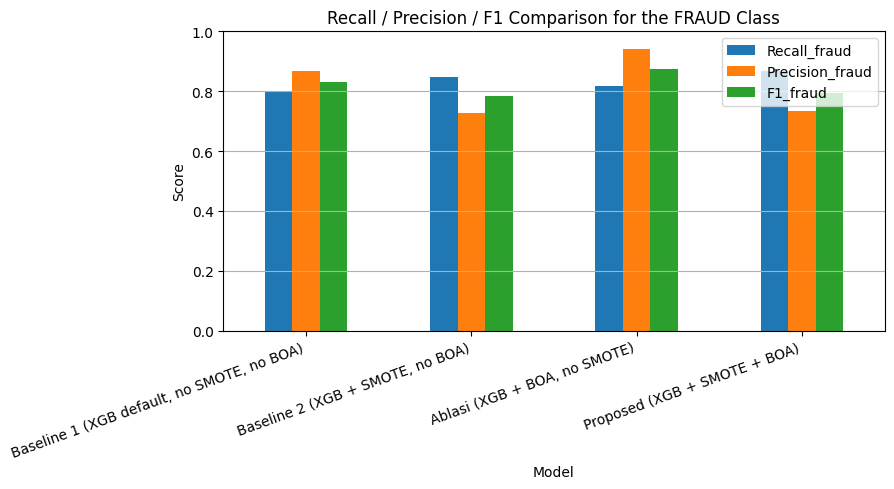

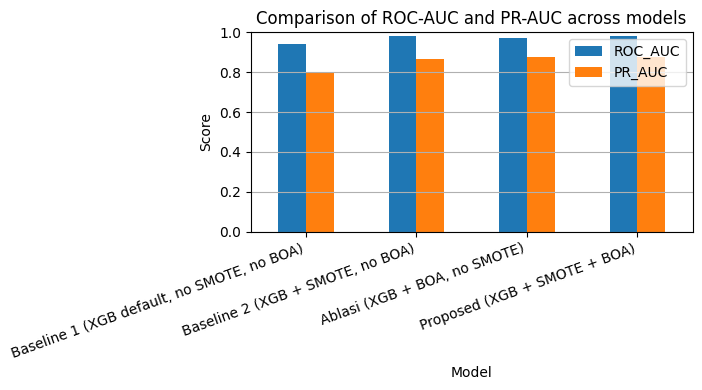

In [21]:
report_b1 = classification_report(y_test, y_pred_b1, output_dict=True)
report_b2 = classification_report(y_test, y_pred_b2, output_dict=True)
report_boa = classification_report(y_test, y_pred,  output_dict=True)
report_boa_nosmote = classification_report(y_test, y_pred_boa_nosmote, output_dict=True)

summary_ablasi = pd.DataFrame([
    {
        "Model": "Baseline 1 (XGB default, no SMOTE, no BOA)",
        "Recall_fraud":  report_b1["1"]["recall"],
        "Precision_fraud": report_b1["1"]["precision"],
        "F1_fraud": report_b1["1"]["f1-score"],
        "ROC_AUC": roc_auc_b1,
        "PR_AUC": pr_auc_b1
    },
    {
        "Model": "Baseline 2 (XGB + SMOTE, no BOA)",
        "Recall_fraud":  report_b2["1"]["recall"],
        "Precision_fraud": report_b2["1"]["precision"],
        "F1_fraud": report_b2["1"]["f1-score"],
         "ROC_AUC": roc_auc_b2,
        "PR_AUC": pr_auc_b2
    },
    {
        "Model": "Ablasi (XGB + BOA, no SMOTE)",
        "Recall_fraud":  report_boa_nosmote["1"]["recall"],
        "Precision_fraud": report_boa_nosmote["1"]["precision"],
        "F1_fraud": report_boa_nosmote["1"]["f1-score"],
        "ROC_AUC": roc_auc_boa_nosmote,
        "PR_AUC": pr_auc_boa_nosmote
    },
    {
        "Model": "Proposed (XGB + SMOTE + BOA)",
        "Recall_fraud":  report_boa["1"]["recall"],
        "Precision_fraud": report_boa["1"]["precision"],
        "F1_fraud": report_boa["1"]["f1-score"],
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc
    }
])
pd.set_option("display.float_format", lambda x: f"{x:0.4f}")
display(summary_ablasi)


fraud_metrics = summary_ablasi.set_index("Model")[["Recall_fraud", "Precision_fraud", "F1_fraud"]]

ax = fraud_metrics.plot(kind="bar", figsize=(9, 5))
ax.set_title("Recall / Precision / F1 Comparison for the FRAUD Class")
ax.set_ylabel("Score")
ax.set_ylim(0.0, 1.0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
ax.grid(axis="y")
plt.tight_layout()
plt.show()

# ---------- PLOT BAR ROC-AUC & PR-AUC ----------
auc_metrics = summary_ablasi.set_index("Model")[["ROC_AUC", "PR_AUC"]]

ax2 = auc_metrics.plot(kind="bar", figsize=(7, 4))
ax2.set_title("Comparison of ROC-AUC and PR-AUC across models")
ax2.set_ylabel("Score")
ax2.set_ylim(0.0, 1.0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=20, ha="right")
ax2.grid(axis="y")
plt.tight_layout()
plt.show()